# Vignette: scRNA-Seq pre-processing - ambient RNA decontamination and doublet removel

1. Read in raw and filtered feature matrices (cellranger-count outputs) and perform ambient RNA decontamination with SoupX.
2. Perform doublet detection on SoupX-cleaned counts with Scrublet and remove doublets from dataset.

*Adapted from workflow by Shreya Johri*

In [3]:
library(Seurat)
library(hdf5r)
library(dplyr)
library(uwot)
library(ggplot2)
library(SoupX)
library(useful)
library(reticulate)

In [4]:
use_python("/broad/software/free/Linux/redhat_6_x86_64/pkgs/python_3.6.3-dupe/lib/python3.6")
use_virtualenv("/broad/VanAllenLab/xchip/cga_home/kevinbi/myenv")

# SoupX for ambient RNA decontamination

Ambient RNA profiles account for a substantial portion of sample-to-sample variability. SoupX provides an approach to (1) determine the ambient profile using low-UMI, non-cell-containing barcodes, (2) estimate the fraction of counts in each droplet accounted for by contaminant, and (3) remove the ambient profile from each droplet, proportional to the contaminant fraction. 

This vignette shows a highly condensed version of a workflow described extensively in the official SoupX vignette, which we highly recommend looking at prior to running this notebook (https://rawcdn.githack.com/constantAmateur/SoupX/6be48cdb0950ed145a3ca6cf235ec2c24d626f81/inst/doc/pbmcTutorial.html).

A neural-network based alternative to SoupX with much less manual input is Cellbender (https://github.com/broadinstitute/CellBender). We currently have an implementation of Cellbender on Terra (ask Kevin to get added to the workspace).

## Loading example data
Raw and filtered UMI count matrices (cellranger-count output). This is a sample from a single patient, P55, in the metastatic clear-cell RCC cohort (unsorted tumor and immune cells from immune checkpoint blockade treated tumors).

In [6]:
toc = Read10X_h5("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/RCC_GENCODE30Liftover/March2020_RCC_Raw/p55/filtered_feature_bc_matrix/filtered_feature_bc_matrix.h5", use.names=TRUE, unique.features=TRUE)
tod = Read10X_h5("/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/RCC_GENCODE30Liftover/March2020_RCC_Raw/p55/filtered_feature_bc_matrix/raw_feature_bc_matrix.h5", use.names=TRUE, unique.features=TRUE)

## Create Seurat object, perform clustering for SoupX
SoupX uses user-supplied groups of cell-type specific genes (e.g. immunoglobulin genes, macrophage markers, hemoglobin genes) to estimate contamination fractions for individual cells. Providing some form of clustering information allows SoupX to "prevent estimation both from cells with high expression of a gene set and any cell that falls in the same cluster."

For this reason we begin by creating a Seurat object with the table of filtered counts, normalizing and scaling, performing PCA, and clustering cells.

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"Centering and scaling data matrix
PC_ 1 
Positive:  CCL4, GZMB, LTB, CCL3, CXCL13, IFNG, HOPX, TRDC, TRGC2, LINC01943 
	   ZNF683, XCL2, FXYD2, XCL1, TNFRSF9, CMC1, GNLY, RGCC, NCR3, CRTAM 
	   PMCH, KRT86, HMGB2, GAS5, LINC02446, TRAF1, PTTG1, ZNF80, LDHB, TNFRSF18 
Negative:  CST3, SERPING1, TMEM176B, FN1, C1QC, CTSL, GRN, IFITM3, FCER1G, TYROBP 
	   TMEM176A, C1QA, CD68, FCGR3A, CTSZ, C1QB, GPX1, SPI1, SERPINA1, CTSB 
	   IFI27, PLTP, CD14, VSIG4, APOC1, NPC2, MARCKS, FCGR1A, C2, APOE 
PC_ 2 
Positive:  CA12, TM4SF1, C1QL1, C1R, SERPINE2, IGFBP3, NDUFA4L2, CPE, C1S, S100A1 
	   RARRES2, NNMT, ANGPTL4, KRT8, FABP6, WFDC2, C19orf33, IGFBP1, KRT18, TPM2 
	   GAL3ST1, S100A16, LINC01320, MET, S100A13, CA9, PAEP, CALD1, MGST1, PDZK1IP1 
Negative:  FCER1G, TYROBP, FCGR3A, C1QC, SPI1, C1QA, C1QB, AIF1, VSIG4, CD14 
	   LYZ, FCGR1A, S100A9, APOE, LST1, APOC1, C1orf162, MSR1, CYBB, LILRB4 
	   MS4A6A, 

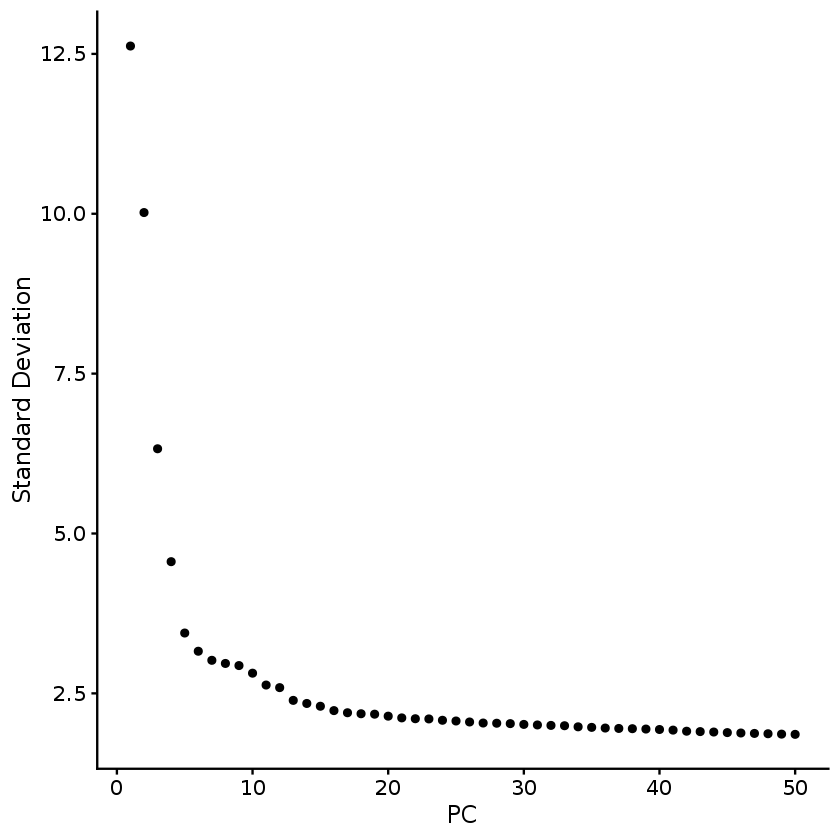

In [7]:
toc_obj = CreateSeuratObject(counts = toc)
toc_obj <- NormalizeData(toc_obj, normalization.method = "LogNormalize", scale.factor = 10000)
toc_obj <- FindVariableFeatures(toc_obj, selection.method = "vst", nfeatures = 5000)
toc_obj <- ScaleData(toc_obj, features = rownames(toc_obj))
toc_obj <- RunPCA(toc_obj, features = VariableFeatures(object = toc_obj))
ElbowPlot(toc_obj, ndims = 50, reduction = "pca")

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5008
Number of edges: 191668

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8555
Number of communities: 8
Elapsed time: 0 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"20:07:27 UMAP embedding parameters a = 0.9922 b = 1.112
20:07:27 Read 5008 rows and found 25 numeric columns
20:07:27 Using Annoy for neighbor search, n_neighbors = 30
20:07:27 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
20:07:29 Writing NN index file to temp file /tmp/21661690.1.interactive/Rtmp3ybMqx/file3eb2847c226
20:07:29 Searching Annoy index using 1 thread, search_k = 3000
20:07:30 Annoy recall = 100%
20:07:31 Commencing smooth kNN distance calibration using 1 thread
20:07:32 Initializing from normalized Laplacian + noise
20:07:32 

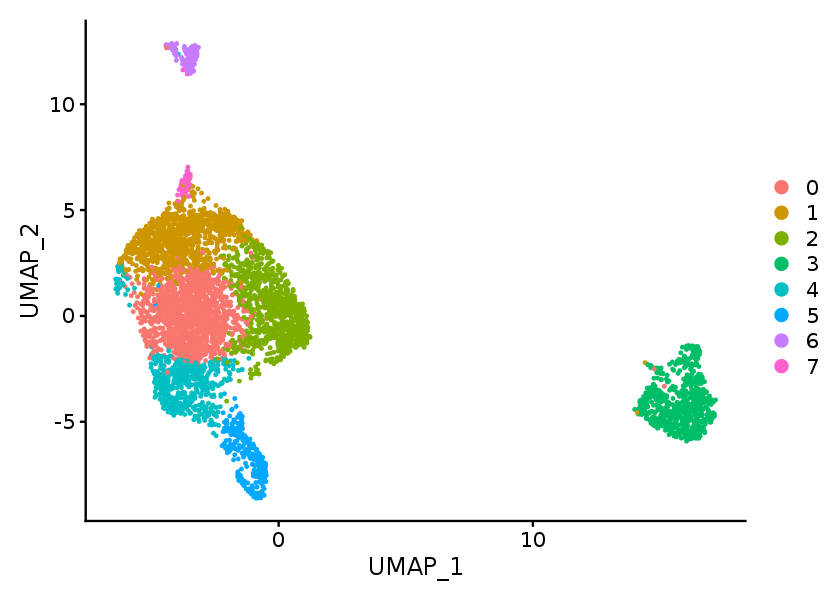

In [8]:
options(repr.plot.width=7, repr.plot.height=5, cex=5)
toc_obj <- FindNeighbors(toc_obj, dims = 1:25)
toc_obj <- FindClusters(toc_obj, resolution = 0.5)
toc_obj <- RunUMAP(toc_obj, dims = 1:25)
toc_obj <- RunTSNE(toc_obj, dims = 1:25)
DimPlot(toc_obj, reduction="umap")

Again we recommend familiarizing yourself with the official SoupX vignette to understand the decision-making process behind choosing groups of genes to use for estimating the contamination fraction. For the following example, we use immunoglobin genes, PTPRC, and macrophage genes.

In [9]:
#Manual Method
igGenes <- c("IGHA1", "IGHA2", "IGHG1", "IGHG2", "IGHG3", "IGHG4", "IGHD", "IGHE", "IGHM",
             "IGLC1", "IGLC2", "IGLC3", "IGLC4", "IGLC5", "IGLC6", "IGLC7", "IGKC")
# hgGenes <- c("HBA1", "HBA2", "HBB", "HBD", "HBE1", "HBG1", "HBG2", "HBM", "HBQ1", "HBZ")
wbcGenes <- c("PTPRC")
macGenes <- c("APOE","APOC1","C1QA","C1QB","C1QC")
# epiGenes <- c("KRT8","KRT18","EPCAM")
# endoGenes <- c("ECSCR","CDH5")
# fbGenes <- c("LUM","FBLN1")

## Create SoupX object, estimate contamination fractions, remove ambient profile

In [13]:
sc = SoupChannel(tod, toc)

sc = setClusters(sc, setNames(toc_obj@meta.data$seurat_clusters, rownames(toc_obj@meta.data)))
#Display top genes contributing to ambient profile
head(sc$soupProfile[order(sc$soupProfile$est, decreasing = TRUE), ], n = 20)

useToEst = estimateNonExpressingCells(sc, nonExpressedGeneList = 
                                      list(IG=igGenes, WBC=wbcGenes, MAC=macGenes))

sc = calculateContaminationFraction(sc, list(IG=igGenes, WBC=wbcGenes, MAC=macGenes), 
                                    useToEst = useToEst)

data = adjustCounts(sc)

,est,counts
,<dbl>,<dbl>
MALAT1,0.034487460,9612
MT-CO2,0.027555524,7680
MT-CO3,0.022869649,6374
MT-CO1,0.021692799,6046
MT-ATP6,0.020677407,5763
TMSB4X,0.016328801,4551
MT-CYB,0.015442575,4304
MT-ND4,0.015360052,4281
B2M,0.014115030,3934


Estimated global contamination fraction of 7.79%
Subtracting contaminating counts
Expanding counts from 8 clusters to 5008 cells.


# Scrublet for doublet detection
The presence of ambient RNAs could result in over-estimation of doublets. For this reason, we perform Scrublet only after some form of ambient decontamination (SoupX or Cellbender).

The official Scrublet vignette can be found here: https://github.com/AllonKleinLab/scrublet/blob/master/examples/scrublet_basics.ipynb

In [14]:
colnames(data) = substr(colnames(data), 1, 16)
scipy_data <- RGF::TO_scipy_sparse(t(data))

nrow(data)
ncol(data)
scipy_data$shape[0]
scipy_data$shape[1]
var2 = ncol(data)

scr <- import("scrublet")
scrub = scr$Scrublet(scipy_data, expected_doublet_rate=0.1)
x=scrub$scrub_doublets(min_counts=2, 
                      min_cells=3, 
                      min_gene_variability_pctl=85, 
                      n_prin_comps=as.integer(30))

[1] 60627

[1] 5008

5008

60627

Below, display expected and detected doublet rates. The latter is preliminary, as this is the detected doublet rate prior to inspection of simulated doublet scores and manual thresholding.

In [15]:
scrub$expected_doublet_rate
scrub$detected_doublet_rate_

[1] 0.1

[1] 0.0009984026

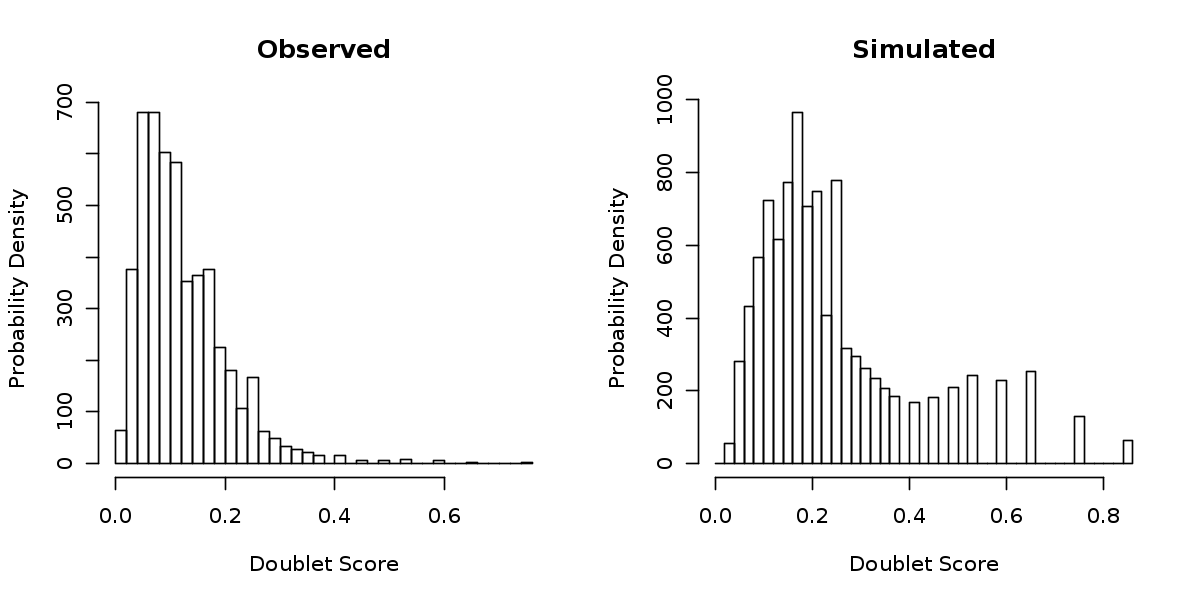

In [16]:
# scrub$plot_histogram()[[1]]
options(repr.plot.width=10, repr.plot.height=5, cex=5)
par(mfrow = c(1, 2))
hist(scrub$doublet_scores_obs_, breaks=30, ylab="Probability Density", xlab="Doublet Score", main="Observed")
hist(scrub$doublet_scores_sim_, breaks=30, ylab="Probability Density", xlab="Doublet Score", main="Simulated")
par(mfrow = c(1, 1))

From the official Scrublet vignette: "To call doublets vs. singlets, we must set a threshold doublet score, ideally at the minimum between the two modes of the simulated doublet histogram." From above, 0.4 seems like a reasonable threshold. Below, we set this cutoff and call doublets accordingly.

In [18]:
cutoff=0.4
var3 = cutoff

In [19]:
umap_coord = as.data.frame(umap(scrub$manifold_obs_, ))
colnames(umap_coord) = c("x_coord","y_coord")
umap_coord[["score"]] = scrub$doublet_scores_obs_

In [20]:
highlight=umap_coord[scrub$call_doublets(threshold=cutoff),]

Below, plot doublets in black (left) and doublet scores as a continuous gradient (right).

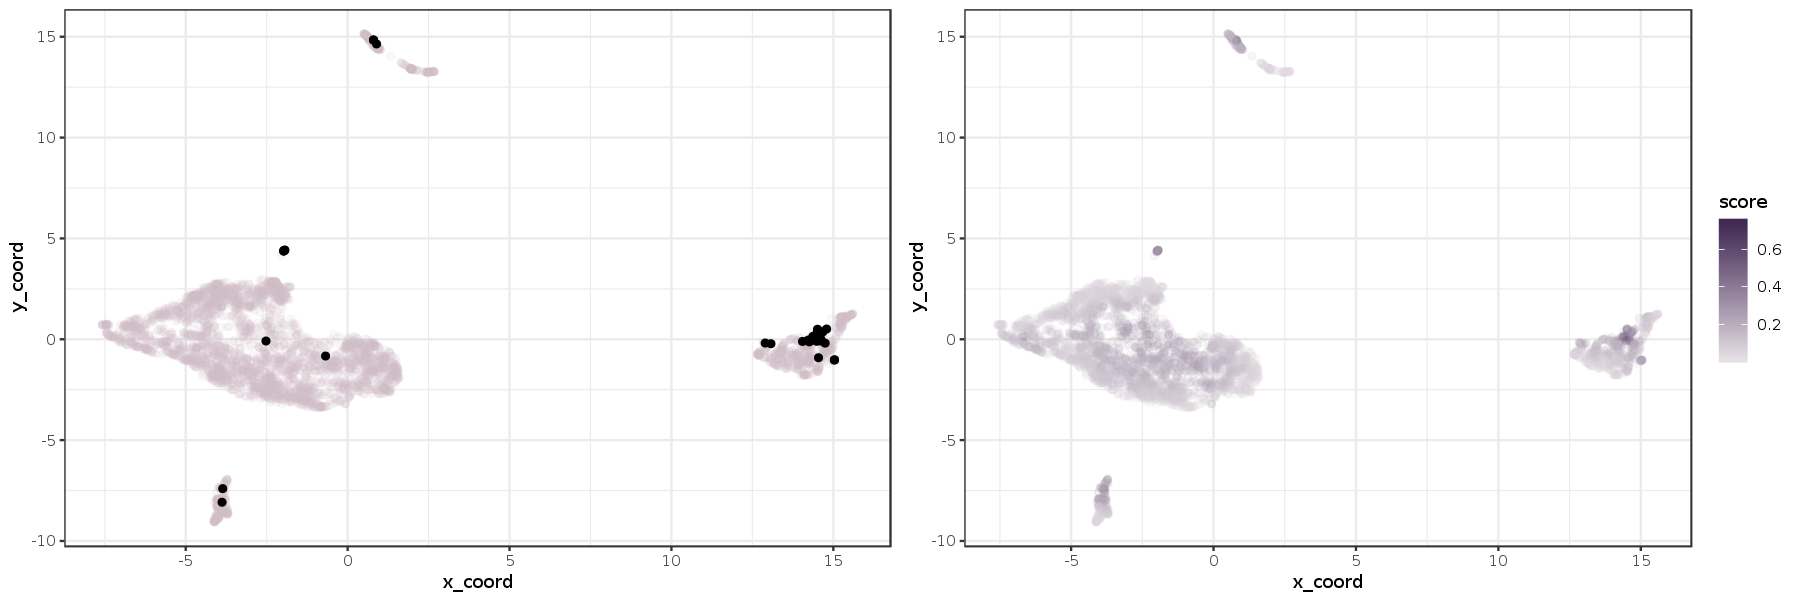

In [21]:
options(repr.plot.width=15, repr.plot.height=5, cex=5)
p1 <- ggplot(umap_coord, aes(x=x_coord,y=y_coord))+ geom_point(color="#D0C3C4", alpha=0.1)+geom_point(data=highlight, color="black")+theme_bw()
p2 <- ggplot(umap_coord, aes(x=x_coord,y=y_coord, color=score))+ geom_point(alpha=0.1)+scale_color_gradient(low="#E6E0E5", high="#402A53")+theme_bw()
gridExtra::grid.arrange(p1,p2, nrow=1)

In [22]:
scrub$detected_doublet_rate_

[1] 0.008985623

Remove doublets from the cleaned counts matrix and save as RDS object.

In [23]:
doublet_free_data = data[,which(scrub$doublet_scores_obs_<cutoff)]
dim(doublet_free_data)
var4 = ncol(doublet_free_data)

[1] 60627  4963

In [25]:
saveRDS(doublet_free_data, file = "/broad/VanAllenLab_CA/xchip/cga_home/kevinbi/RCC_GENCODE30Liftover/March2020_RCC_Raw/p55/P55_SoupX_Scrublet_Cleaned_RawMatrix.RDS")